[**LINK TO COLAB**](https://colab.research.google.com/drive/14QhkHTXdk6EKKyXxSRC_voUaNzJNBSMq)

# **Lab 4: Function Approximation**
**Edvin von Platen**

# **Abstract**

In this report we present and implement the Assemble System algorithm which is a general method for assembling a system of equations which solution is an approximation of some function. We then assemble a system for $L^2$ projection to piecewise linear polynomials over a mesh in one dimension.

The implementation appears to be sound and performs well even for more complex functions.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [0]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Edvin von Platen (edvinvp@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

# **Introduction**

The Assemble System algorithm is a general method for assembling equation system which solution is an approximation of some function. The algorithm is general in the sense that by only modifying the function calls within the algorithm we can change the approximation method used.

We implement functions for the assembly of a system for $L^2$ projection to piecewise linear polynomials over a mesh in one dimension.

All referenced material can be found in the course [DD2363 Methods in Scientific Computing](https://kth.instructure.com/courses/17068) lecture notes.


# **Methods**

### **L2 Projection to Piecewise Linear Approximation over Mesh in 1D**
We have implemented Algorithm 9.2, Assemble system, for piecewise linear approxiamtion in one dimension according to example 9.11.

The idea is to use $L^2$ projection to project a function $f\in L^2(I)$ onto the space of continious piecewise linear polynomials $V_h^{(1)}$, the projection $P_h f(x)$ over the interval $I$, divided in $m+1$ intervals, is given by (9.13),
$$
P_h f(x) = \sum_{j=0}^{m+1} \alpha_j \phi_j(x).
$$
where $\phi_j(x)$ is the basis functions (9.7),
$$
\phi_j(x) = \begin{cases}
\lambda_{j,1}(x), & x \in I_j, \\
\lambda_{j+1,0}(x), & x\in I_{j+1}, \\
0, & otherwise.
\end{cases}
$$
defined by the local linear Lagrange shape functions for subinterval $I_j$,
$$
\lambda_{j,0} = \frac{x_j - x}{h_j}, \ \ \ \lambda_{j,1} = \frac{x - x_{k-1}}{h_k}.
$$
We are to determine the coordinates $\alpha_j$ in (9.13), which can be done by solving the system,
$$
A\alpha = b.
$$
$A$ is known as the *mass* matrix $(a_{ij}) = (\phi_j, \phi_i)$, $b$ as the *load* vector $b_i = (f,\phi_i)$, and $\alpha$ as the *solution* vector. 

We use the analytical integrals computed in (9.14), (9.15), and (9.16) for the mass matrix values, 
\begin{align*}
a_{ii} &= (\phi_i,\phi_i) = \int_0^1 \phi_i^2(x)dx) = \int_{I_i} \lambda_{i,1}^2 (x) dx + \int_{ I_{i+1} } \lambda_{i+1,0}^2(x) dx \\
&= \frac{h_i}{3} + \frac{h_{i+1}}{3}, \\
a_{ii+1} &=  \frac{h_{i+1}}{6}, \\
a_{ii-1} &= \frac{h_i}{6}.
\end{align*}
The load vector is given by (9.17),
$$
b_i = (f,\phi_i) = \int_0^1 f(x) dx = \int_{I_i} \lambda_{i,1}(x)f(x)dx + \int_{I_{i+1}}\lambda_{i+1,0}f(x)dx.
$$
While we could compute the integrals for each point $x_i$, it is more efficient to iterate over the subintervals and compute the integrals one subinterval at a time. For each subinterval $k$ we build a $2\times 2$ local mass matrix and a $2 \times 1$ local load vector, since we use linear polynomials. We then add the local matrix and vector to their global counterpart. I.e. only one term of the integral sums for $a_{ii}$ and $b_i$ are computed in a subinterval, the two terms are then added in the global matrix and vector. We use the scipy.integrate.quad function to numerically integrate $b_i$.

The assembly method is implemented inside the class L2_approx, which may not be optimal for the portability of the assemble_system method, but it suits our use case well.

In [0]:
class L2_approx:

  def __init__(self, points):
    self.points = points
    m = len(points)
    self.global_matrix = np.zeros((m,m))
    self.global_vector = np.zeros(m)
  
  def reset(self, points):
    self.points = points
    m = len(points)
    self.global_matrix = np.zeros((m,m))
    self.global_vector = np.zeros(m)

  def get_no_local_shape_functions(self, k):
    return 1

  def get_local_to_global_map(self, k):
    return (k,k+1)

  def integrate_vector(self, f, k, i):
    loc2glob = self.get_local_to_global_map(k)
    h = abs(self.points[loc2glob[0]] - self.points[loc2glob[1]])
    if i == 0:
      g = lambda x: f(x) * (self.points[loc2glob[1]] - x) / h
      return integrate.quad(g, self.points[loc2glob[0]], self.points[loc2glob[1]])[0]
    elif i == 1:
      g = lambda x: f(x) * (x - self.points[loc2glob[0]]) / h 
      return integrate.quad(g, self.points[loc2glob[0]], self.points[loc2glob[1]])[0]

  def integrate_matrix(self,k, i, j):
    loc2glob = self.get_local_to_global_map(k)
    h = abs(self.points[loc2glob[0]] - self.points[loc2glob[1]])
    if i == j:
      return h/3
    elif j == i + 1 or j == i - 1:
      return h/6
    else:
      return 0

  def add_to_global_vector(self, b, loc2glob):
    self.global_vector[loc2glob[0]] += b[0]
    self.global_vector[loc2glob[1]] += b[1]
                
  def add_to_global_matrix(self, A, loc2glob,k):
    i,j = loc2glob
    self.global_matrix[i,i] += A[0,0]
    self.global_matrix[i,j] += A[0,1]
    self.global_matrix[i+1,i] += A[1,0]
    self.global_matrix[j,j] = +A[1,1]

  def assemble_system(self, f, no_subintervals):
    for k in range(0,no_subintervals):
      q = self.get_no_local_shape_functions(k)
      loc2glob = self.get_local_to_global_map(k)
      A = np.zeros((q+1,q+1))
      b = np.zeros((q+1))
      for i in range(q+1):
        b[i] = self.integrate_vector(f,k,i)
        for j in range(q+1):
          A[i,j] = self.integrate_matrix(k,i,j)
      self.add_to_global_vector(b,loc2glob)
      self.add_to_global_matrix(A,loc2glob,k)
  
  def solve(self):
    return np.linalg.solve(self.global_matrix, self.global_vector)

# **Results**

In this section we test the accuracy and convergence rate of the implementation compared to the exact function.

We start with a simple polynomial $p(x) = x^2 - 5$ on the interval $I = [-5,5]$, and $n=100$ points.

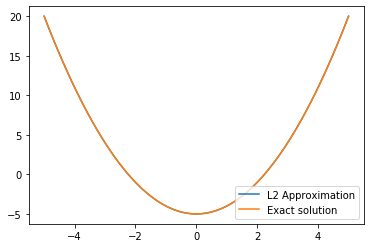

In [6]:
test = L2_approx([])
points = np.linspace(-5,5,100)
test.reset(points)
test.assemble_system(lambda x: x*x - 5, len(points) - 1)
res = test.solve()
plt.plot(points,res,label='L2 Approximation')
y = list(map(lambda x: x*x - 5, points))
plt.plot(points, y,label='Exact solution')
plt.legend(loc='lower right')

We see that the two graphs appear to be completely overlapping, but to verify the accuracy we compute the absolute error between the approximation and the exact solution.

In [7]:
err = list(map(lambda x,y: abs(x-y), res, y))
print(err)

[0.0017005067505344584, 0.0017005067514297423, 0.001700506750825781, 0.0017005067508577554, 0.0017005067513444772, 0.0017005067506925542, 0.0017005067511526306, 0.0017005067511277616, 0.0017005067507476213, 0.0017005067512876337, 0.0017005067507991356, 0.001700506751154407, 0.001700506750935915, 0.0017005067510424965, 0.001700506750960784, 0.001700506751085129, 0.0017005067509696659, 0.0017005067510291738, 0.0017005067509865412, 0.001700506751030062, 0.0017005067510225125, 0.0017005067510025285, 0.0017005067510034166, 0.0017005067510216243, 0.0017005067510162952, 0.0017005067510078575, 0.001700506751010189, 0.001700506751013825, 0.0017005067510094118, 0.0017005067510139638, 0.0017005067510111882, 0.0017005067510114102, 0.0017005067510118543, 0.0017005067510122984, 0.001700506751010522, 0.0017005067510122984, 0.0017005067510114102, 0.0017005067510114102, 0.001700506751010078, 0.0017005067510136307, 0.0017005067510122984, 0.0017005067510114102, 0.0017005067510122984, 0.001700506751011410

The error is stationary around $0.0017$.

We continue by approximating the more difficult function,
$$
f(x) = \frac{e^xsin(x)}{(x+1)^6}, x \in [0,20].
$$
using $n=10$ and $n=50$ points.

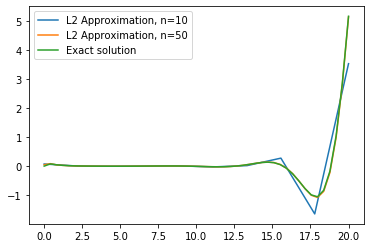

In [9]:
f = lambda x: np.exp(x)*np.sin(x)/((x+1)**6)
test = L2_approx([])
points_10 = np.linspace(0,20,10)
points_50 = np.linspace(0,20,50)
test.reset(points_10)
test.assemble_system(f, len(points_10) - 1)
res_10 = test.solve()
plt.plot(points_10,res_10,label='L2 Approximation, n=10')

test.reset(points_50)
test.assemble_system(f, len(points_50) - 1)
res_50 = test.solve()
plt.plot(points_50,res_50,label='L2 Approximation, n=50')

y_50 = list(map(f, points_50))
y_10 = list(map(f, points_10))
plt.plot(points_50, y_50,label='Exact solution')
plt.legend(loc='upper left')

Using $n=10$ points the approximation deterioates quite severly at the end point.

We inspect the error for $n=10$,

[0.07355078666533793, 0.0049438535846924835, 0.0005807159419306102, 0.0002946754470500468, 0.0038508469644417467, 0.005502726092008508, 0.03155112708412108, 0.23334010327642518, 0.5934990308028445, 1.6339585905136835]


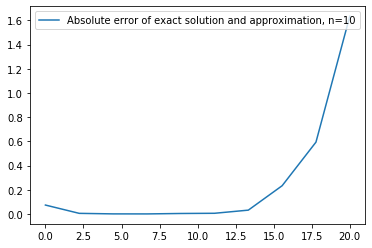

In [14]:
err = list(map(lambda x,y: abs(x-y), res_10, y_10))
print(err)
plt.plot(points_10, err, label='Absolute error of exact solution and approximation, n=10')
plt.legend(loc='upper left')

We see that the error increases when $f(x)$ grows.

# **Discussion**

The implementation appear to be sound and the results appear to be quite accurate, at least when using smaller step sizes. I was quite surprised at how accurate the method is for more difficult functions, even if its in only one dimension. The part of the implementation which was the most challenging for me was definitely understanding the assembly of $b$, and that only one term was to be computed each subinterval.